This notebook will:
- Download ZTF alerts for a named SN from the DESY archive.
- Load a set of AMPEL feature extraction and ML classification units.
- Apply these to each phase of the transient, using an assumbed redshift.
- Plot the evolution of SNIa probability provided by each classifier.

In [1]:
# Name (ZTF ID) of transient and redshift to use (when relevant)
#snname = "ZTF20aaumsrr"  # Ia
snname = "ZTF24abhgzjl"  # Ia
#snname = "ZTF24abiesnr" # Ibn
z_assumed = 0.063

In [2]:
import os
import requests
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
import seaborn as sns
import numpy as np

# Base AMPEL tools
from ampel.log.AmpelLogger import AmpelLogger
from ampel.content.T1Document import T1Document 
from ampel.dev.DevAmpelContext import DevAmpelContext
from ampel_notebook_utils import api_get_datapoints

# Units linking to feature extraction and ML algorithms
from ampel.contrib.hu.t2.T2RunParsnipRiseDecline import T2RunParsnipRiseDecline
from ampel.contrib.hu.t2.T2RunParsnipRiseDecline import get_probability_evolution

In [3]:
# Path to AMPEL configuration file
AMPEL_CONF = '/home/jnordin/github/ampelJul24/Ampel-HU-astro/ampel_conf.yaml'
# Personal access token to the DESY ZTF archive
token = os.environ["ARCHIVE_TOKEN"]

In [4]:
# Parse the system for paths to analysis units
ctx = DevAmpelContext.load(
    config = AMPEL_CONF,
    db_prefix = 'dumpme',
    purge_db = False,
)

### Obtain data from archive

In [5]:
dps = api_get_datapoints(snname, token)
print(f'Found {len(dps)} datapoints')

Found 92 datapoints


In [6]:
# Make sure datapoints sorted according to increasing time 
dps = sorted(dps, key=lambda x: x['body']['jd'])

In [7]:
# Record detection date for plotting
jddet = min([dp['body']['jd'] for dp in dps if 'magpsf' in dp['body']])
print(f'First detected at JD {jddet}')

First detected at JD 2460566.8370139


### Configure and loading classifiers

In [8]:
# This configuration file is provided in full
# It lists the detailed descrpiptor of all classifiers to use, including local paths to 
# classifier input files.
rdp_config = { 
   'classifier_name': 'rdp',
   'classifier_version': "0.1",
   't_cadence': 3.,
   'significant_bands': ['ztfg',  'ztfr', 'ztfi'],
   'paths_parsnip': {
       'snlong': {
                'model': '/home/jnordin/data/parsnip/parsnip_ps1_ztf.pt',
                'classifier': '/home/jnordin/data/parsnip/ztf_classifier.pkl',
       }
    },
    'paths_xgbmulti': {
        'sample1': {
            'path': '/home/jnordin/data/noiztf/v240809/xgb_models/model_sn_long_sample1',
            'classes': [ "slsn", "snia", "snibc", "snii", "sniin" ],
        },
        'later': {
            'path': '/home/jnordin/github/ampelJul24/Ampel-HU-astro/scripts/risedecline_sets_v2/late/models_multivar/sn_long/model_sn_long',
            'classes': [ "slsn", "snia", "snibc", "snii", "sniin" ],
        },
        'early': {
            'path': '/home/jnordin/github/ampelJul24/Ampel-HU-astro/scripts/risedecline_sets_v2/early/models_multivar/sn_long/model_sn_long',
            'classes': [ "slsn", "snia", "snibc", "snii", "sniin" ],
        },
        'last_parsnip': {
            'path': '/home/jnordin/github/ampelJul24/Ampel-HU-astro/scripts/risedecline_sets_v2/lastalert/pa/models_multivar/sn_long/model_sn_long',
            'classes': [ "slsn", "snia", "snibc", "snii", "sniin" ],
        },
        'last_risedec': {
            'path': '/home/jnordin/github/ampelJul24/Ampel-HU-astro/scripts/risedecline_sets_v2/lastalert/rd/models_multivar/sn_long/model_sn_long',
            'classes': [ "slsn", "snia", "snibc", "snii", "sniin" ],
        },
        'last_prd': {
            'path': '/home/jnordin/github/ampelJul24/Ampel-HU-astro/scripts/risedecline_sets_v2/lastalert/rdp/models_multivar/sn_long/model_sn_long',
            'classes': [ "slsn", "snia", "snibc", "snii", "sniin" ],
        }
    },
    'add_parsnip_from': 'snlong', 
    'parsnipplot_suffix': 'png',
    'parsnipplot_dir': '/home/jnordin/tmp/ztfparsnip_fp',
    'fixed_z': z_assumed,
    'redshift_kind': None,
    'return_features': True,
    'tabulator': [ {'unit': 'ZTFT2Tabulator'} ],                
    't2_dependency': [],
}

In [9]:
# Model/result labeling corresponding to the above, used while plotting.
classlabeling = {
    'Parsnip': {'targetname': 'SNIa', 'model': 'parsnip', 'training': 'snlong' },
    'XRDSampling': {'targetname': 'snia', 'model': 'xgbmulti', 'training': 'sample1' },    
    'XRDPostpeak': {'targetname': 'snia', 'model': 'xgbmulti', 'training': 'later' },    
    'XRDEarly': {'targetname': 'snia', 'model': 'xgbmulti', 'training': 'early' },    
    'XParsnipLast': {'targetname': 'snia', 'model': 'xgbmulti', 'training': 'last_parsnip' },    
    'XRDLast': {'targetname': 'snia', 'model': 'xgbmulti', 'training': 'last_risedec' },    
    'XRDPLast': {'targetname': 'snia', 'model': 'xgbmulti', 'training': 'last_prd' },    
}

In [10]:
# Load base classifier unit 
t2unit = T2RunParsnipRiseDecline( **rdp_config, logger=AmpelLogger.get_logger() )

In [11]:
# Read classifier files 
t2unit.post_init()

### Run classifiers.
Loop through each dp, gradually increase dps range and study evolution of probability. 

In [12]:
classifier_results = []
for k in range(len(dps)):
    if not 'magpsf' in dps[k]['body']:
        continue
    print("Alert {} @ JD {}".format(k, dps[k]['body']['jd'] ))
    classifier_results.append( t2unit.process(T1Document(stock=dps[0]['stock'], link=0), dps[0:k+1], t2_views=[]) )

Alert 28 @ JD 2460566.8370139
Alert 31 @ JD 2460569.7738657
Alert 32 @ JD 2460569.8155208
Alert 34 @ JD 2460575.7961574
Alert 37 @ JD 2460576.8525231
Alert 41 @ JD 2460577.8696528
Alert 46 @ JD 2460578.911875
Alert 47 @ JD 2460578.9123495
Alert 48 @ JD 2460578.9128241
Alert 50 @ JD 2460579.7920486
Alert 51 @ JD 2460579.8315278
Alert 57 @ JD 2460582.88375
Alert 58 @ JD 2460582.8846875
Alert 59 @ JD 2460582.9032407
Alert 63 @ JD 2460583.9432407
Alert 64 @ JD 2460585.7371991
Alert 65 @ JD 2460585.760463
Alert 66 @ JD 2460585.78375
Alert 67 @ JD 2460585.8070023
Alert 68 @ JD 2460585.8302894
Alert 69 @ JD 2460585.8535532
Alert 70 @ JD 2460585.8865625
Alert 71 @ JD 2460585.9099306
Alert 72 @ JD 2460585.9333102
Alert 73 @ JD 2460585.9568056
Alert 75 @ JD 2460586.6282292
Alert 76 @ JD 2460586.666956
Alert 77 @ JD 2460586.6890394
Alert 78 @ JD 2460586.712419
Alert 79 @ JD 2460586.7356944
Alert 80 @ JD 2460586.7589815
Alert 81 @ JD 2460586.7822338
Alert 82 @ JD 2460586.8055093
Alert 83 @ JD 2460

### Plot results 

<Figure size 1200x1200 with 0 Axes>

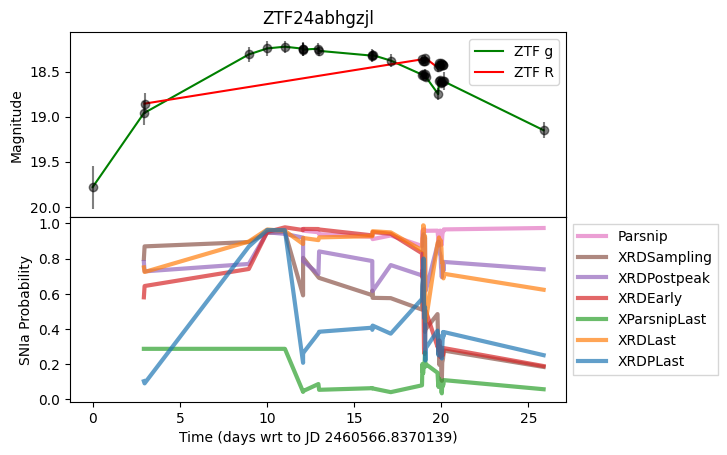

In [13]:
_ = plt.figure(1,figsize=(12,12))

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

plt.subplot(2,1,1)

plt.title( snname )

# g
phot = np.array( [
            (dp['body']['jd']-jddet,dp['body']['magpsf'],dp['body']['sigmapsf']) 
            for dp in dps if 'magpsf' in dp['body'] and dp['body']['fid']==1 
])
if len(phot)>0:
    ax = sns.lineplot(x=phot[:,0],y=phot[:,1], label='ZTF g', color='green')
    ax.errorbar(phot[:,0], phot[:,1], yerr=phot[:,2], fmt='o', color='k', alpha=0.5)

# R
phot = np.array( [
            (dp['body']['jd']-jddet,dp['body']['magpsf'],dp['body']['sigmapsf']) 
            for dp in dps if 'magpsf' in dp['body'] and dp['body']['fid']==2 
])
if len(phot)>0:
    ax = sns.lineplot(x=phot[:,0],y=phot[:,1], label='ZTF R', color='red')
    ax.errorbar(phot[:,0], phot[:,1], yerr=phot[:,2], fmt='o', color='k', alpha=0.5)

# i
phot = np.array( [
            (dp['body']['jd']-jddet,dp['body']['magpsf'],dp['body']['sigmapsf']) 
            for dp in dps if 'magpsf' in dp['body'] and dp['body']['fid']==3 
])
if len(phot)>0:
    ax = sns.lineplot(x=phot[:,0],y=phot[:,1], label='ZTF i', color='green')
    ax.errorbar(phot[:,0], phot[:,1], yerr=phot[:,2], fmt='o', color='k', alpha=0.5)

plt.gca().invert_yaxis()
plt.xlabel('Time (days wrt to JD {}'.format(jddet))
plt.ylabel('Magnitude')


plt.subplot(2,1,2)

colors = sns.color_palette(n_colors=len(classlabeling))
for modellabel, modelkeys in classlabeling.items():
    t, c = get_probability_evolution( classifier_results, modelkeys['targetname'], modelkeys['model'], classlabel=modelkeys['training'] )
    sns.lineplot(x=[ti-jddet for ti in t],y=c, label=modellabel, color=colors.pop(), linewidth=3, alpha=0.7 )

plt.ylabel('SNIa Probability')
plt.xlabel('Time (days wrt to JD {})'.format(jddet))

_ = plt.legend(loc=1, bbox_to_anchor=(1.32, 1.),
          fancybox=False, shadow=False, ncol=1)
plt.show()